# ASTR598 - Astrostatistics     
## Homework 2, part 3
### Group 1.

In [124]:
import numpy as np
import pandas as pd
import astropy as apy
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy import units as units
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord

from astroML.stats import binned_statistic_2d

In [140]:
% matplotlib inline
setup_text_plots(fontsize=16, usetex=True)

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["font.size"] = 24
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

### Read all GalFast simulated data

In [176]:
data = np.loadtxt('data/Galfast-Stripe82.txt')
table = Table(rows=data, names=("ra", "dec", "glon", "glat", "pmra", "pmdec", "px", "rv", "Teff", "FeH",
                                "log(g)", "u", "g", "r", "i", "z", "y"))

### Filter the data for objects of interest

In [201]:
def filter_rmag(table, rlim=(20.5, 21)):
    """
    Applies a r-band magnitude filter to the table, such that the returned dataset satisfies:
        rlim[0] < table < rlim[1]
    """
    rmask = (table['r']>rlim[0]) & (table['r']<rlim[1])
    return table[rmask]

def filter_color(table, gmilim=(0.3, 0.4)):
    """
    Applies a g-i color filter to the table, such that the returned dataset satisfies:
        gmilim[0] < table < gmilim[1]
    """
    gmi = table['g']-table['i']
    gmimask = (gmi>gmilim[0]) & (gmi<gmilim[1])
    return table[gmimask]

def filter_ra(table, ralim=(25, 40)):
    """
    Applies a right ascension coordiante filter to the table, such that the returned dataset satisfies:
        ralim[0] < table < ralim[1]
    """
    ramask = (table['ra']>ralim[0]) & (table['ra']<ralim[1])
    return table[ramask]

def filter_abs_pm(table, pmlim = (-0.001, 100)):
    """
    Applies an absolute proper motion filter to the table, such that the returned dataset satisfies:
        pmlim[0] < table < pmlim[1]
    where abspm is taken to be np.sqrt(pmra**2 + pmdec**2)
    """
    abspm = np.sqrt(table['pmra']**2 + table['pmdec']**2)
    abspmmask = (abspm>pmlim[0]) & (abspm<pmlim[1])
    return table[abspmmask]  

filters = [filter_rmag, filter_color, filter_ra, filter_abs_pm]
defaults = [f.__defaults__ for f in filters]

def apply_filters(table, filters=filters):
    """
    Applies filters provided in the filters kwarg, in order in which they are given, to the table.
    
    table:   dataset (numpy.void, astropy.Table...)
    filters: an iterable containing the filter functions in order in which they are to be applied 
             to the dataset
    """
    for f in filters:
        table = f(table)
    return table

# being lazy and unpythonic
def change_defaults(func, defaults):
    func.__defaults__ = (defaults, )

def revert_defaults():
    for f, defs in zip(filters, defaults):
        change_defaults(f, defs[0])

### Plot function

In [178]:
def hess_gri_pm(table, title="", colorby="abspm", colorlabel=None, statistic="median"):    
    """
    For a given dataset constructs a Hess plot of Ra vs r-band magnitudes where the coloring represents
    the median absolute proper motion of objects in that bin. 
    
    table: dataset to be plotted, has to contain keywords "pmra", "pmdec", "ra" and "r"
    title: title of the plot
    """
    if colorby == "abspm":
        stat = np.sqrt(table['pmra']**2 + table['pmdec']**2)
        colorlabel = r'Proper Motion (mas/yr)'
    else:
        stat = table[colorby]
        colorlabel = colorlabel
    nbins = int(3*len(table)**(1.0 / 4.0))
    
    medpm, xedges, yedges = binned_statistic_2d(table['ra'], table['r'], stat, 
                                                statistic=statistic, bins=nbins)
    
    plt.imshow(medpm.T, origin='lower',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   aspect='auto', interpolation='nearest')

    cb = plt.colorbar(orientation='horizontal')
    cb.set_label(colorlabel, fontsize=22)
    #plt.clim(0, 30) # This was set by hand to draw out as much detail as possible

    plt.xlabel(r'Ra', fontsize=22)
    plt.ylabel(r'r', fontsize=22)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.title(title)
    plt.show()

### Plot data and analysis

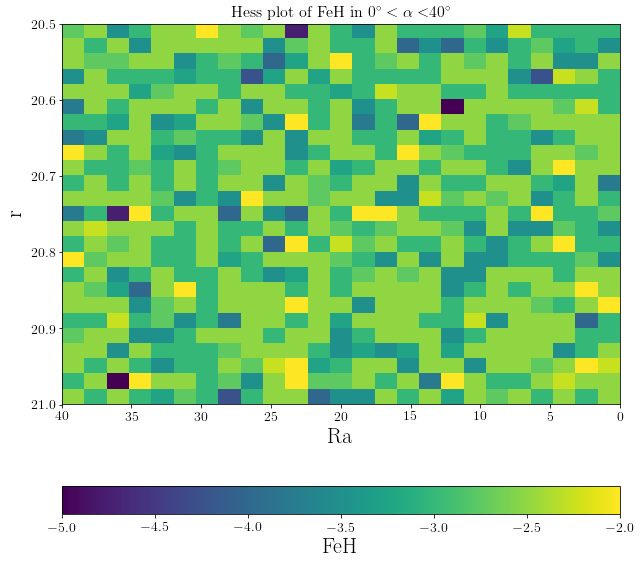

In [213]:
change_defaults(filter_ra, (0, 40))
table3 = apply_filters(table)
revert_defaults()

hess_gri_pm(table3, title=r"Hess plot of FeH in 0$^\circ<\alpha<$40$^\circ$", colorby="FeH", colorlabel="FeH")

There are 1943 objects with 20.5<r<21, 0.3<g-i<0.4 and 25<Ra<40


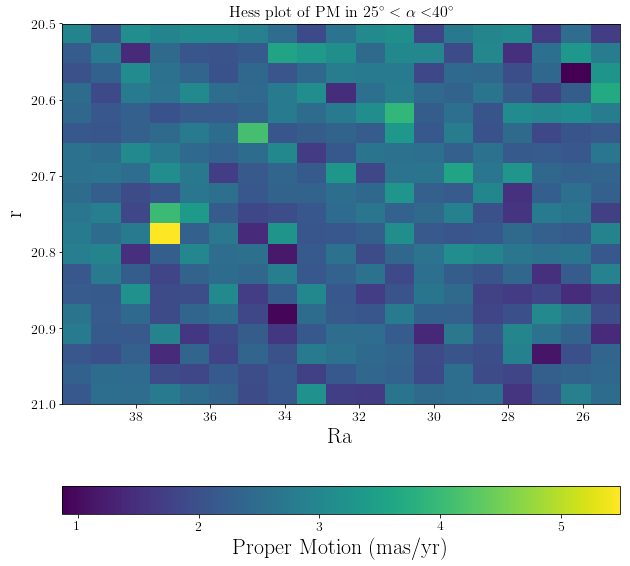

In [210]:
change_defaults(filter_ra, (25, 40))
change_defaults(filter_abs_pm, (-0.0001, 20))
table1 = apply_filters(table)
revert_defaults()

print(r"There are {0} objects with 20.5<r<21, 0.3<g-i<0.4 and 25<Ra<40".format(len(table1)))
hess_gri_pm(table1, r"Hess plot of PM in 25$^\circ<\alpha<$40$^\circ$")

There are 2102 objects with 20.5<r<21, 0.3<g-i<0.4 and 0<Ra<15


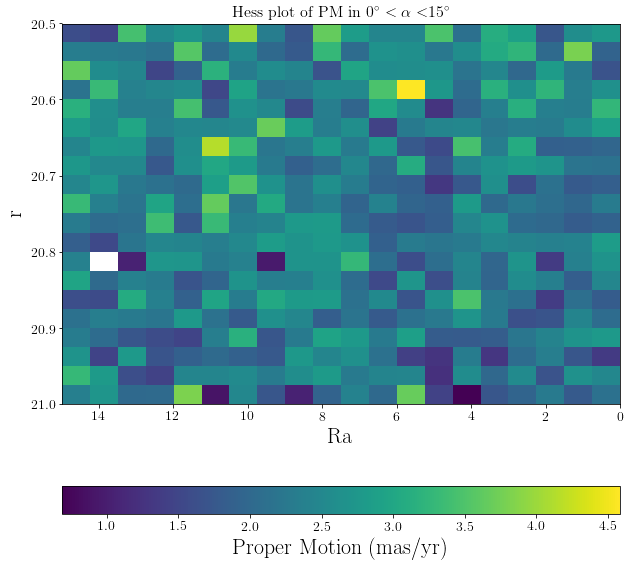

In [205]:
# being lazy and unpythonic...
change_defaults(filter_ra, (0, 15))
table2 = apply_filters(table)
revert_defaults()
print(r"There are {0} objects with 20.5<r<21, 0.3<g-i<0.4 and 0<Ra<15".format(len(table2)))

hess_gri_pm(table2, title=r"Hess plot of PM in 0$^\circ<\alpha<$15$^\circ$")